# Linkers

Review of all the linkers implemented in ByoTrack. For more details, have a look at the documentation or implementation of each linker.
___________________________________________________

1. **NearestNeighborLinker** (Frame by frame linker using euclidean distance association)
2. **KalmanLinker** (Frame by frame linker that models motion with Kalman filters and use maximum likelihood association
3. **KOFTLinker** (Frame by frame linker that models motion using Optical Flow enhanced Kalman filters and maximum likelihood association)
4. **IcyEMHTLinker** (Wrapper around Icy EMHT algorithm that uses Kalman filters and multiple hypothesis association)
2. **TrackMateLinker** (Wrapper around u-track/TrackMate from Fiji. It uses Kalman filters and euclidean distance based association)

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import byotrack
import byotrack.example_data
import byotrack.visualize

## Load a video

In [2]:
# Open an example video
video = byotrack.example_data.hydra_neurons()[130:]  # Let's start at frame 130 where the animal is contracting

# Or provide a path to one of your video
#video = byotrack.Video("path/to/video.ext")

# Or load manually a video as a numpy array
# video = np.random.randn(50, 500, 500, 3)  # T, H, W, C

In [3]:
TEST = True  # Set to False to analyze a whole video

if TEST:
    video = video[:50]  # Temporal slicing to analyze only the first 50 frames

In [4]:
# A transform can be added to normalize and aggregate channels

transform_config = byotrack.VideoTransformConfig(aggregate=True, normalize=True, q_min=0.01, q_max=0.999, smooth_clip=1.0)
video.set_transform(transform_config)

# Show the min max value used to clip and normalize
print(video._normalizer.mini, video._normalizer.maxi)

[0.] [248.]


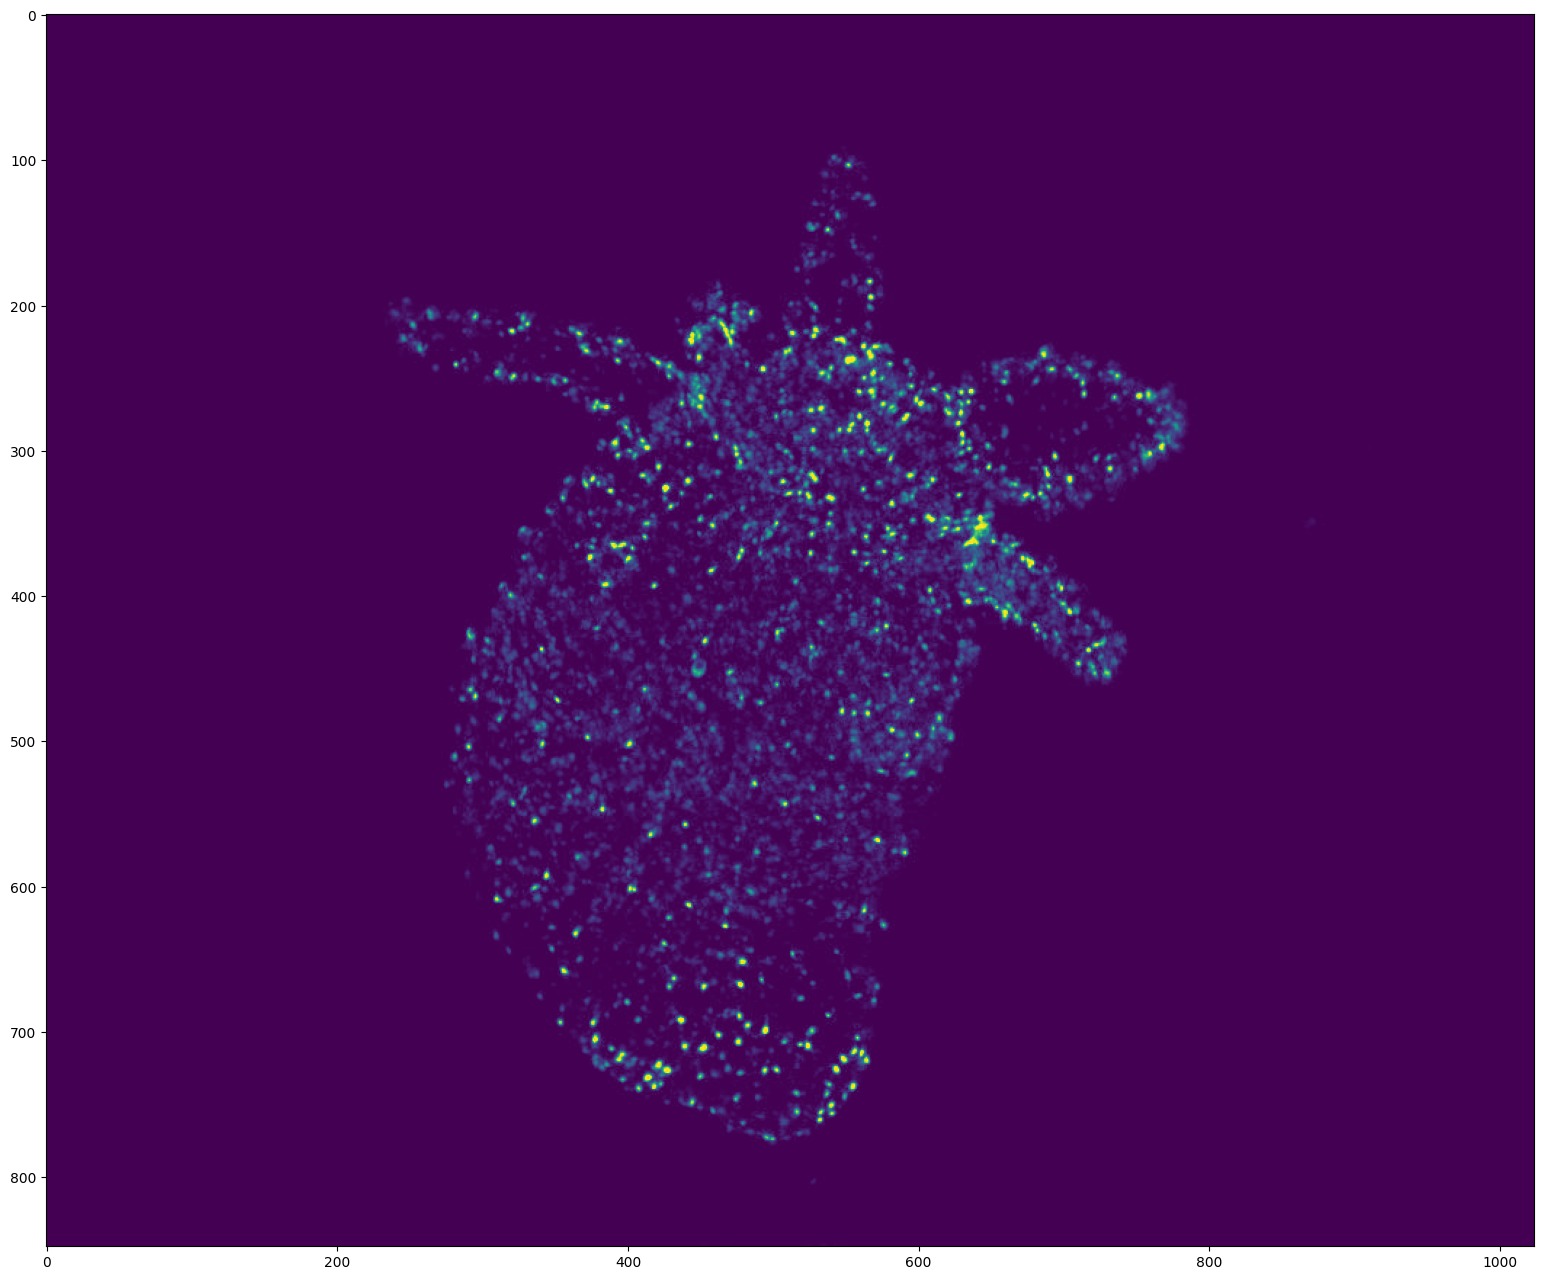

In [5]:
# Display the first frame

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(video[0])
plt.show()

In [6]:
# Display the video with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v to switch on/off the display of the video

byotrack.visualize.InteractiveVisualizer(video).run()

## Detections

The linker links detections through time. We use the WaveletDetector from byotrack as an example to produce the detections.

In [7]:
# Create the detector object with its hyper parameters
from byotrack.implementation.detector.wavelet import WaveletDetector

detector = WaveletDetector(scale=1, k=3.0, min_area=5.0, batch_size=20, device=torch.device("cpu"))

In [8]:
# Run the detection process on the current video

detections_sequence = detector.run(video)

Detections (Wavelet):   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
# Display the detections with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v to switch on/off the display of the video
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence).run()

## NearestNeighborLinker

In [10]:
from byotrack.implementation.linker.frame_by_frame.nearest_neighbor import NearestNeighborLinker, NearestNeighborParameters, AssociationMethod

In [11]:
# See documentation about the Linker

NearestNeighborLinker?

In [12]:
# See documentation about the Linker parameters

NearestNeighborParameters?

In [13]:
# Create the linker
# We set only the main parameters
# You can look at the documentation to see the other ones

specs = NearestNeighborParameters(
    association_threshold=10.0,  # Most important one: Don't link if the euclidean distance is greater than 10 pixels
    n_valid=3,  # Validate a track after three consecutive detections
    n_gap=3,  # At most 3 consecutive missed detections
    association_method="opt_smooth"  # See AssociationMethod?, you can use greedy which is faster but usually less performant
)

linker = NearestNeighborLinker(specs)

In [14]:
# Run the linker

tracks = linker.run(video, detections_sequence)

Nearest Neighbor linking:   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

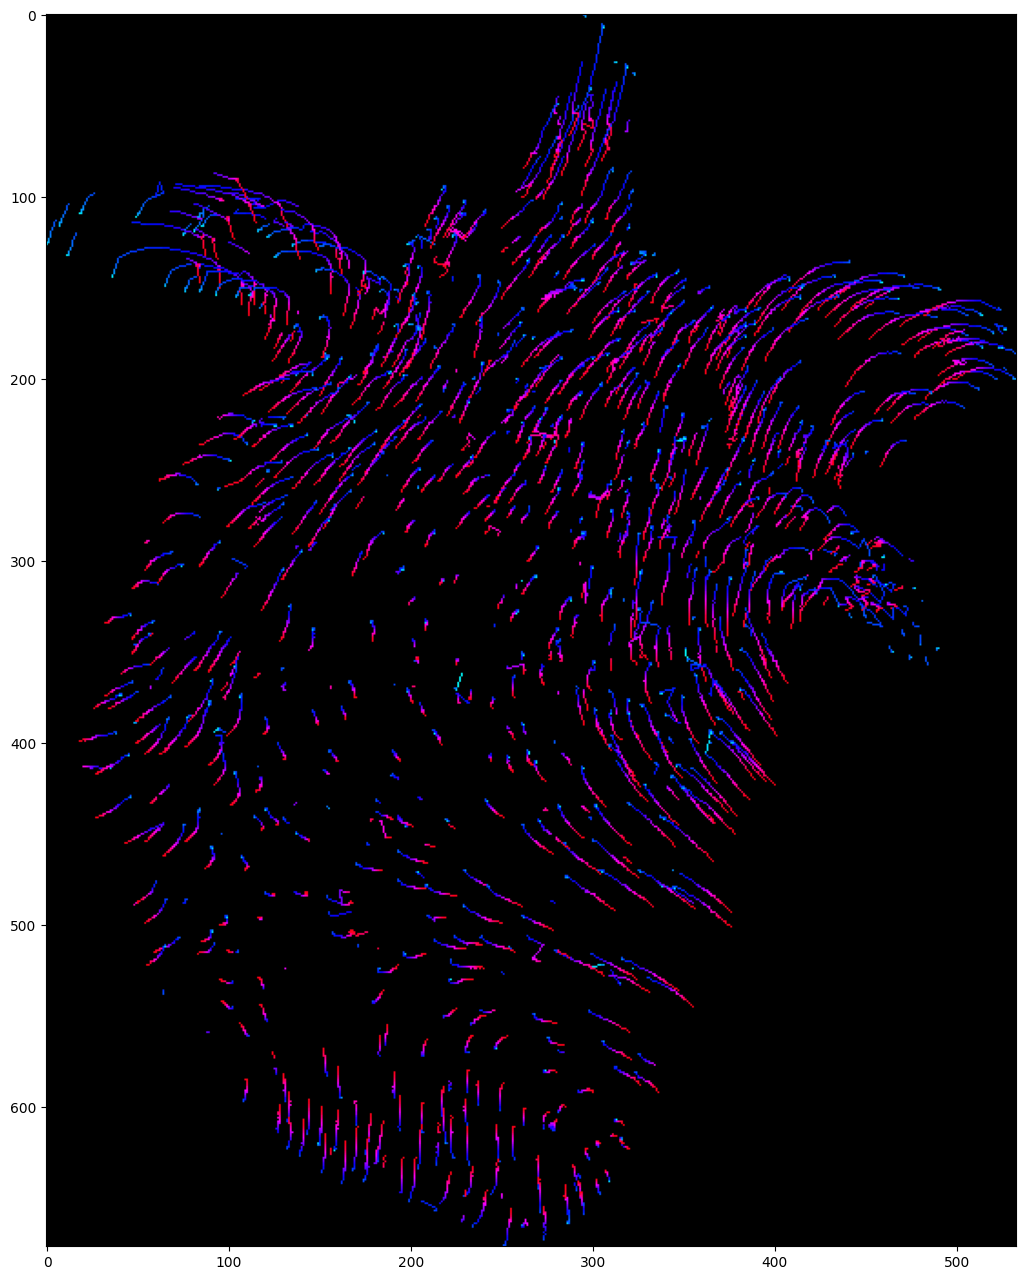

In [16]:
# Project tracks onto a single image and color by time

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=None,
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

## KalmanLinker

In [17]:
from byotrack.implementation.linker.frame_by_frame.kalman_linker import KalmanLinker, KalmanLinkerParameters, Cost

In [18]:
# See documentation about the Linker

KalmanLinker?

In [19]:
# See documentation about the Linker parameters

KalmanLinkerParameters?

In [20]:
# Create the linker
# We set only the main parameters.
# You can look at the documentation to see the other ones.

specs = KalmanLinkerParameters(
    association_threshold=1e-3,  # Most important parameter: don't link if the association likelihood is smaller than 1e-4.
    detection_std=3.0,  # Detections location are precise up to 3.0 pixels
    process_std=3.0,  # Kalman filter predictions are precise up to 3.0 pixels
    kalman_order=1,  # Order of the kalman filter
    cost="likelihood",  # See Cost? to see which other cost are available, by default it uses Euclidean distance (And association threshod should be express in pixels)
)

linker = KalmanLinker(specs)

In [21]:
# Run the linker

tracks = linker.run(video, detections_sequence)

Kalman filter linking:   0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

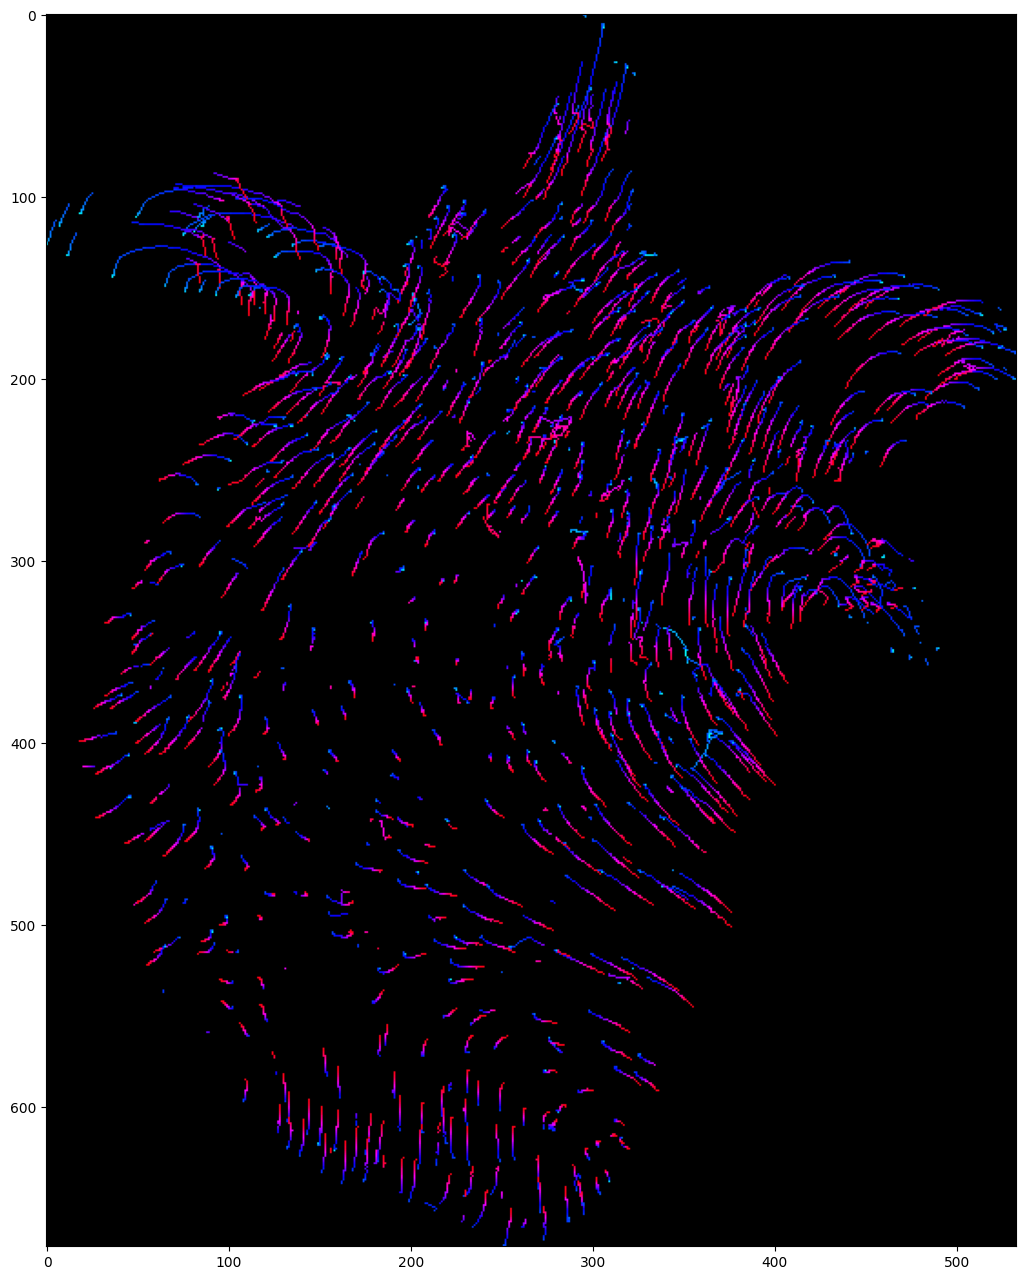

In [23]:
# Project tracks onto a single image and color by time

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=None,
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

## KOFTLinker

In [24]:
from byotrack.implementation.linker.frame_by_frame.koft import KOFTLinker, KOFTLinkerParameters

In [25]:
# See documentation about the Linker

KOFTLinker?

In [26]:
# See documentation about the Linker parameters

KOFTLinkerParameters?

In [27]:
# Koft requires optical flow (NOTE: that optical flow can also be efficiently be used with the two previous linker)

# You could use any optical flow algorithm, but ByoTrack already supports OpenCV and Skimage implementations.
# Let's use Farneback from OpenCV (no extra dependencies)

import cv2
from byotrack.implementation.optical_flow.opencv import OpenCVOpticalFlow

optflow = OpenCVOpticalFlow(cv2.FarnebackOpticalFlow_create(winSize=20), downscale=4)

In [28]:
# Before linking, let's check visually that the optical flow algorithm works
# We sample a grid of points that are moved by the flow computed.
# The computed flows are good if the points roughly follows the video motion

# Use w/x to move forward in time (or space to run/pause the video)
# Use g to reset the grid of points

byotrack.visualize.InteractiveFlowVisualizer(video, optflow).run()

In [29]:
# Create the linker
# We set only the main parameters.
# You can look at the documentation to see the other ones.

specs = KOFTLinkerParameters(
    association_threshold=2e-3,  # Most important parameter: don't link if the association likelihood is smaller than 1e-3.
    detection_std=3.0,  # Detections location are precise up to 3.0 pixels
    process_std=1.5,  # Kalman filter predictions are precise up to 3.0 pixels
    flow_std=1.0,  # Optical flow predictions are precise up to 1.0 pixels/frame
    kalman_order=1,  # Order of the kalman filter
    n_gap=5,  # Allow to link after 5 consecutive missed detections
    cost="likelihood",  # See Cost? to see which other cost are available, by default it uses Euclidean distance (And association threshod should be express in pixels)
)

linker = KOFTLinker(specs, optflow)

In [30]:
# Run the linker

tracks = linker.run(video, detections_sequence)

KOFT linking:   0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

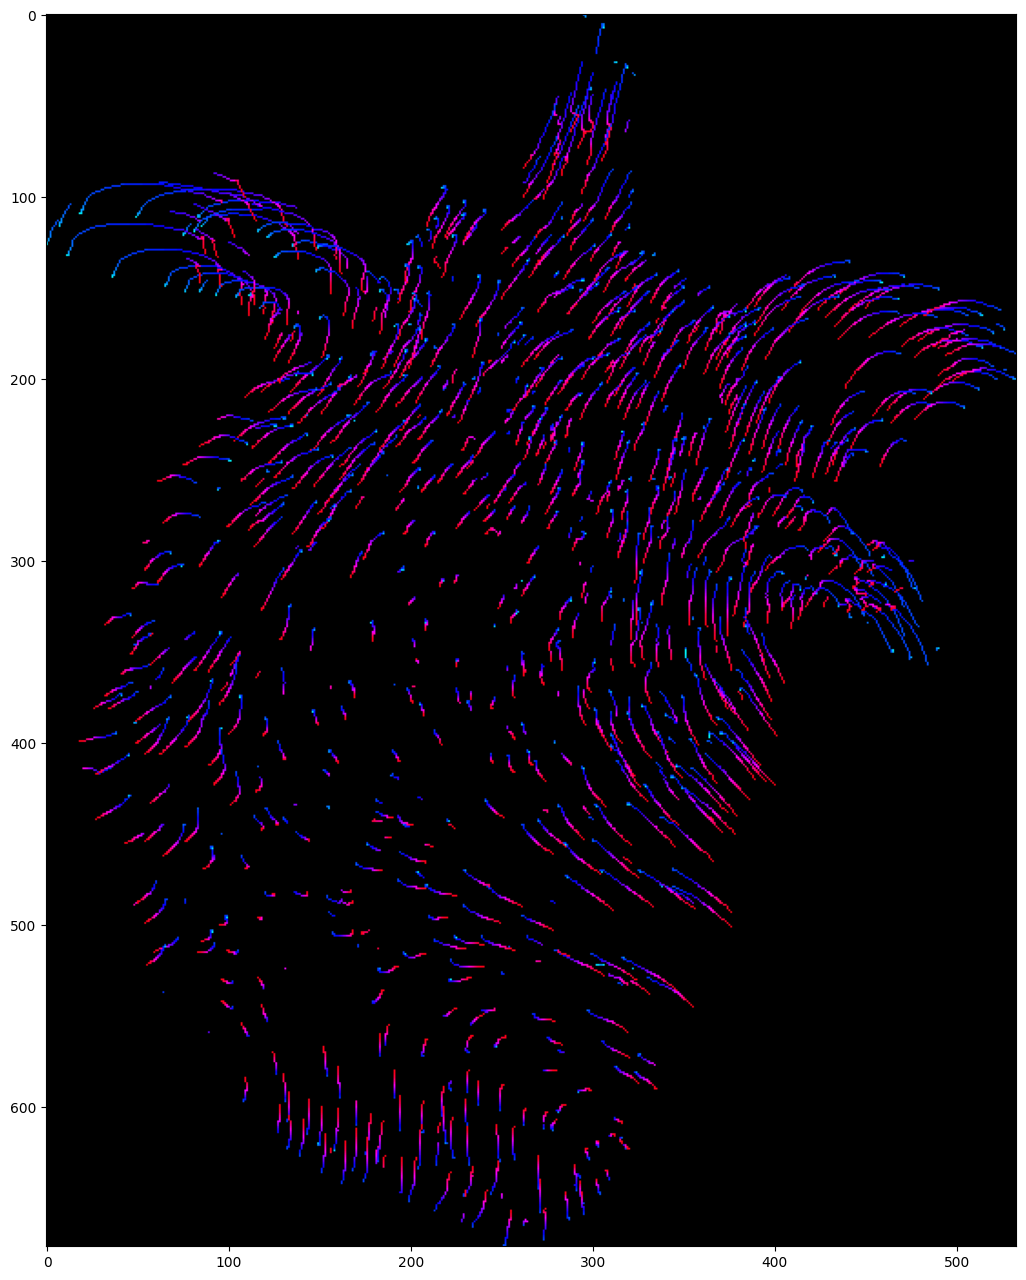

In [32]:
# Project tracks onto a single image and color by time

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=None,
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

## EMHT (Icy)

Icy software must be installed

In [33]:
from byotrack.implementation.linker.icy_emht import IcyEMHTLinker, Motion, EMHTParameters

In [34]:
# See documentation about the Linker

IcyEMHTLinker?

In [35]:
# See documentation about the Linker parameters

EMHTParameters?

In [36]:
# Create the linker object with icy path
# This Linker requires to install Icy software first

icy_path = "path/to/icy/icy.jar"
motion = Motion.MULTI  # Can also be DIRECTED or MULTI (both)

if True:  # Set full specs with EMHTParameters
    # You can choose to set manually the parameters. See EMHTParameters
    # the more important ones are:
    # - gate_factor: How greedy the linking is. (Default to 4.0) more or less equivalent to the association_threshold
    #       of KalmanLinker with a Mahalanobis Cost.
    # - motion: Motion model to consider: Can be BROWNIAN, DIRECTED or MULTI. (Default is BROWNIAN)
    #       Brownian <=> kalman_order = 0, Directed <=> kalman_order = 1 (MULTI uses both)
    # - tree_depth: MHT tree depth. Higher values are usually more performant, but much more expensive
    #             If the tracking is too slow or too ram intensive, you may reduce this value. (Default 4)
    parameters = EMHTParameters(gate_factor=4.0, motion=motion, tree_depth=2)
    linker = IcyEMHTLinker(icy_path, parameters)
else:  # Do not provide specs, parameters will be estimated by Icy (We do not advise this solution)
    linker = IcyEMHTLinker(icy_path)
    linker.motion = motion  # Set motion afterwards if no parameters are provided

In [37]:
# Run the linker

tracks = linker.run(video, detections_sequence)

Calling Icy with: java -jar icy.jar -hl -x plugins.adufour.protocols.Protocols protocol="/home/rreme/workspace/pasteur/byotrack/byotrack/implementation/linker/icy_emht/emht_protocol_with_full_specs.xml" rois="/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_rois.xml" parameters="/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_parameters.xml" tracks="/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_tracks.xml"
[DEBUG] 2024-07-04 15:25:22 - Initializing...


JarResources.loadJar(/home/rreme/workspace/pasteur/icy-app-v3/plugins/nchenouard/particletracking/sequenceGenerator/._tracking-benchmark-generator-2.0.0.jar) error:
java.util.zip.ZipException: zip END header not found



[INFO] 2024-07-04 15:25:22 - Java(TM) SE Runtime Environment 21.0.1+12-LTS-29 (64 bit)
[INFO] 2024-07-04 15:25:22 - Running on Linux 5.15.0-107-generic (amd64)
[INFO] 2024-07-04 15:25:22 - System total memory: 32.6 GB
[INFO] 2024-07-04 15:25:22 - System available memory: 5.7 GB
[INFO] 2024-07-04 15:25:22 - Max Java memory: 8.2 GB
[INFO] 2024-07-04 15:25:22 - Headless mode.
[INFO] 2024-07-04 15:25:22 - Icy v3.0.0a started.
[DEBUG] 2024-07-04 15:25:23 - Magic name is Spot Tracking
[DEBUG] 2024-07-04 15:25:23 - Magic icon is /plugins/nchenouard/particletracking/simplifiedMHT/detectionIcon.png
[DEBUG] 2024-07-04 15:25:23 - Magic name is EzPlug tutorial
[DEBUG] 2024-07-04 15:25:23 - Magic icon is /plugins/adufour/ezplug/ezplug.png
Loading workflow...


Error(s) while loading protocol:
Variable 'useLPSolver' not found in block 'Spot tracking do tracking'. It may have been removed or renamed.
--


Converted from 31443 ROI(s)
Non binaryaction at frame 3
Non binaryaction at frame 9
Non binaryaction at frame 46
Track extraction at frame 49
[INFO] 2024-07-04 15:25:38 - Exiting...
[INFO] 2024-07-04 15:25:38 - Done.


In [38]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

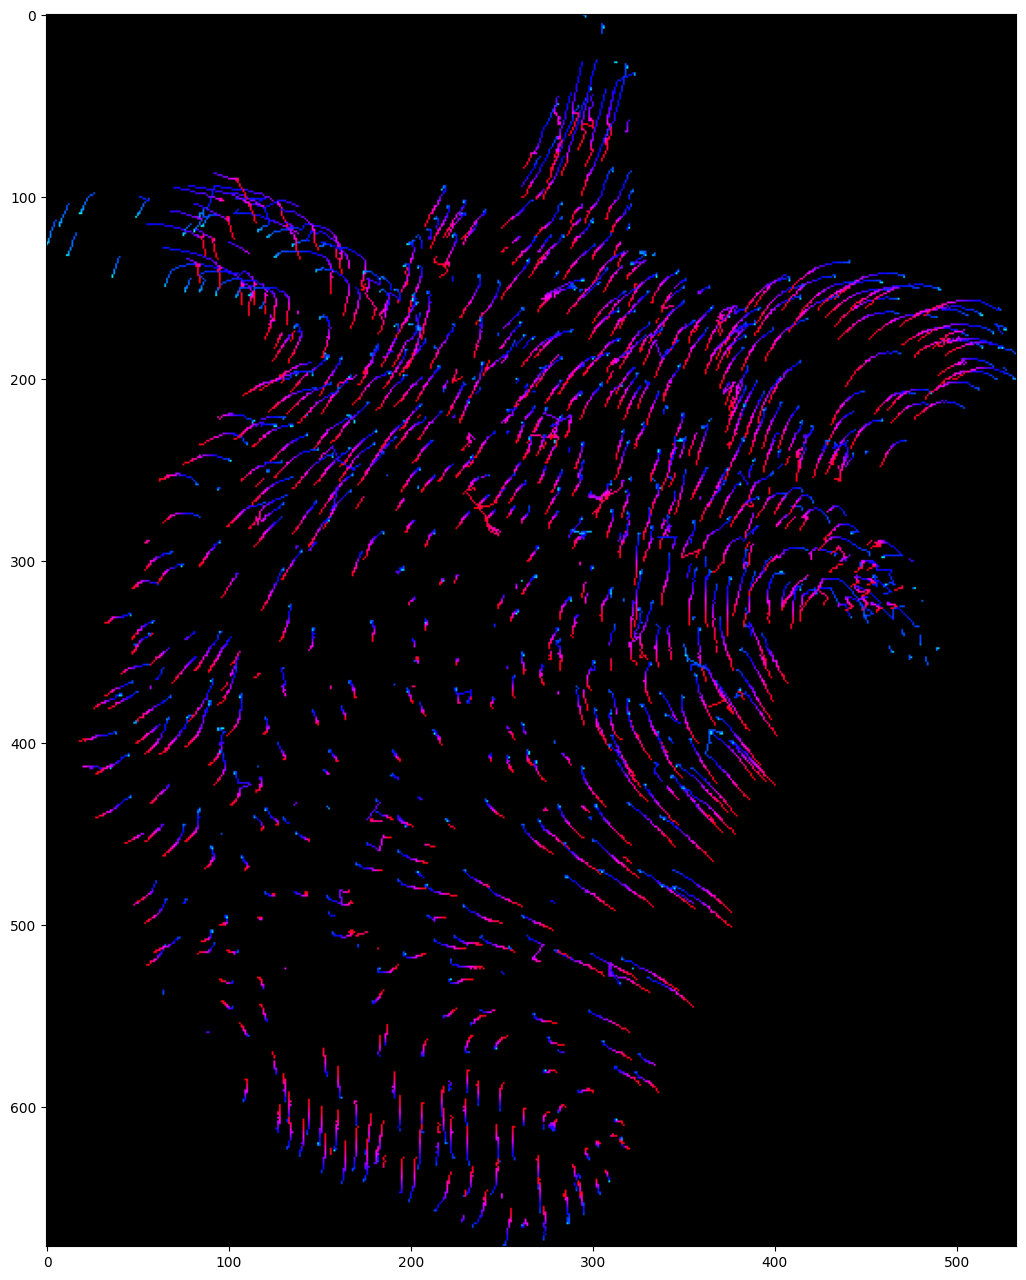

In [39]:
# Project tracks onto a single image and color by time

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=None,
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

## TrackMate (Fiji)

ImageJ/Fiji software must be installed

In [40]:
from byotrack.implementation.linker.trackmate import TrackMateLinker, TrackMateParameters

In [41]:
# See documentation about the Linker

TrackMateLinker?

In [42]:
# See documentation about the Linker parameters

TrackMateParameters?

In [43]:
# Create the linker object with fiji path
# This Linker requires to install Fiji software first
# We set only the main parameters.
# You can look at the documentation to see the other ones.

fiji_path = "path/to/Fiji.app/ImageJ-os"

specs = TrackMateParameters(
    linking_max_distance=10.0,  # Max linking euclidean distance (pixels) between consecutive spots
    max_frame_gap=4,  # Max diff in frames to allow gap closing. Here it allows 3 consecutives missed detections
    gap_closing_max_distance=15.0,  # Max gap closing euclidean distance (pixels).
    kalman_search_radius=10.0  # When set, it enables Kalman filters, and replace the linking_max_distance (except for the first two spots association)
)


linker = TrackMateLinker(fiji_path, specs)

In [44]:
# Run the linker

tracks = linker.run(video, detections_sequence)

Calling Fiji with: ./ImageJ-linux64 --ij2 --headless --console --run "/home/rreme/workspace/pasteur/byotrack/byotrack/implementation/linker/trackmate/_trackmate.py" "detections='/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_detections.tif',parameters='/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_parameters.json',tracks='/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_tracks.xml'"


OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


Hello from ImageJ/Fiji
('Loading detections from', u'/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_detections.tif')
Settings:
{u'MAX_FRAME_GAP': 4, u'ALTERNATIVE_LINKING_COST_FACTOR': 1.05, u'KALMAN_SEARCH_RADIUS': 10.0, u'LINKING_FEATURE_PENALTIES': {}, u'LINKING_MAX_DISTANCE': 10.0, u'GAP_CLOSING_MAX_DISTANCE': 15.0, u'MERGING_FEATURE_PENALTIES': {}, u'SPLITTING_MAX_DISTANCE': 15.0, u'BLOCKING_VALUE': inf, u'ALLOW_GAP_CLOSING': True, u'ALLOW_TRACK_SPLITTING': False, u'ALLOW_TRACK_MERGING': False, u'MERGING_MAX_DISTANCE': 15.0, u'SPLITTING_FEATURE_PENALTIES': {}, u'CUTOFF_PERCENTILE': 0.9, u'GAP_CLOSING_FEATURE_PENALTIES': {}}
Starting detection process using 16 threads.
Detection processes 16 frames simultaneously and allocates 1 thread per frame.
Detection...
Found 31443 spots.

Starting initial filtering process.
Computing spot features over 16 frames simultaneously and allocating 1 thread per frame.
Calculating 31443 spots features...

Computation done in 2 

In [45]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

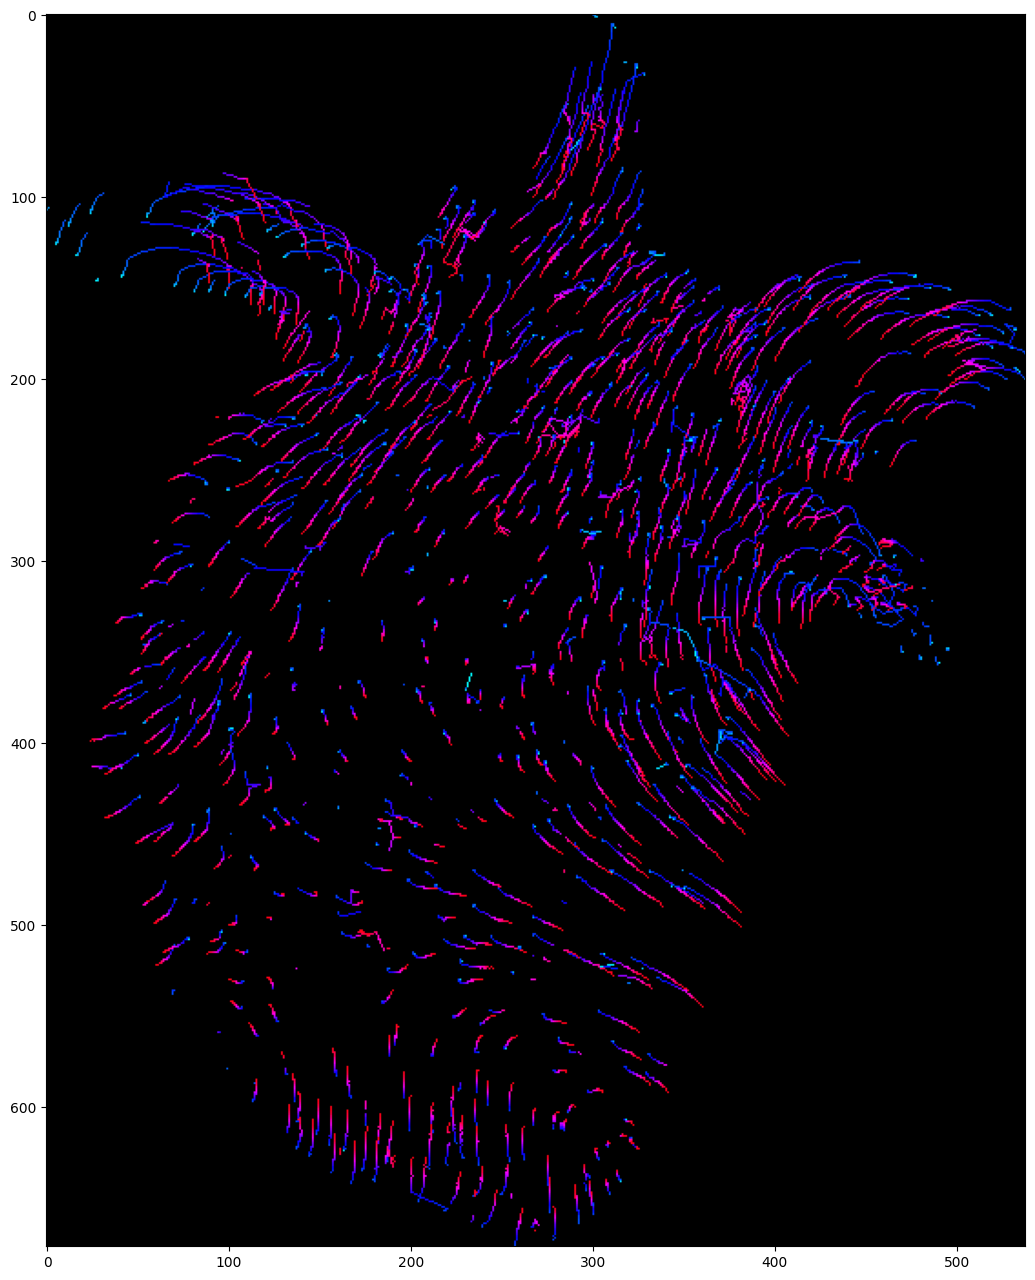

In [46]:
# Project tracks onto a single image and color by time

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=None,
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()